In [1]:
%load_ext autoreload
%autoreload 2

# Replicate loci chart

In [2]:
# change main directory
import sys
sys.path.append('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/tesis_code/repos/loci')

import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\amaguaya\OneDrive - Kienzle Automotive GmbH\Desktop\tesis_code\repos\loci\local_run_test


## Main imports

In [ ]:
from sklearn.preprocessing import StandardScaler
from causa.loci import loci, loci_w_marginal
from causa.datasets import MNU, Tuebingen, SIM, SIMc, SIMG, SIMln, Cha, Multi, Net
from causa.utils import plot_pair

from sympy import im
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from causa.utils import TensorDataLoader

from nflows.transforms import CompositeTransform, ReversePermutation, AffineCouplingTransform
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.nn.nets import MLP, ResidualNet
from math import ceil
from nflows.flows import SimpleRealNVP
from torch.nn import functional as F
from torch.nn.functional import relu
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from torch.distributions import Normal


1.9675503745183327


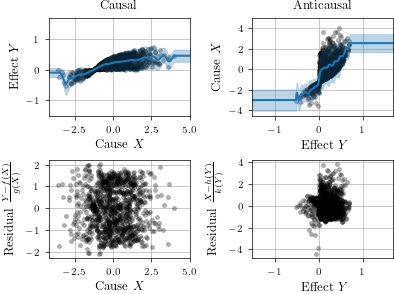

In [5]:
# We use the MNU pair 55 as an example and without standardized data
dataset = MNU(55, preprocessor=None, double=True)
x, y = dataset.cause.flatten().numpy(), dataset.effect.flatten().numpy()
# This function call shows all options of LOCI, we return_function to visualize the estimator
score, f_forward, f_reverse = loci(
    x, y, independence_test=False, neural_network=False, 
    return_function=True, n_steps=100
)
print(score)
plot_pair(x, y, f_forward, f_reverse)

0.1601669200689846


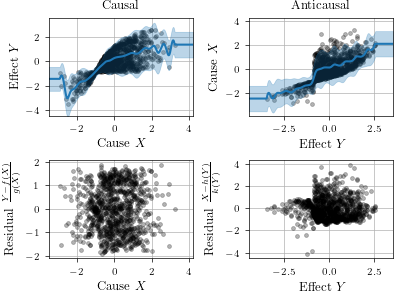

In [6]:
# We use the MNU pair 55 as an example and standardized data
dataset = MNU(55, preprocessor=StandardScaler(), double=True)
x, y = dataset.cause.flatten().numpy(), dataset.effect.flatten().numpy()
# This function call shows all options of LOCI, we return_function to visualize the estimator
score, f_forward, f_reverse = loci(
    x, y, independence_test=False, neural_network=False, 
    return_function=True, n_steps=100
)
print(score)
plot_pair(x, y, f_forward, f_reverse)

## First test - using without noise during modelling
### RealNVP -(Real-valued non-volume preserving) using nflows library

- here, we can check a sample with no normal distribution and check the performance of this method

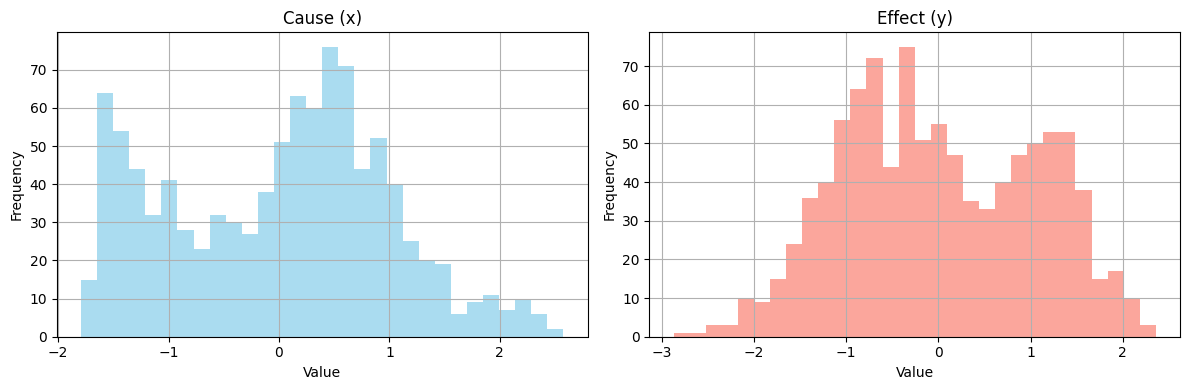

In [7]:
# We use the MNU pair 55 as an example and standardize the data
# dataset = MNU(100, preprocessor=None, double=True)
# dataset = Tuebingen(108, preprocessor=None, double=True)
dataset = SIM(100, preprocessor=None, double=True)
# dataset = SIMc(90, preprocessor=None, double=True)
# dataset = SIMG(100, preprocessor=None, double=True)
# dataset = SIMln(100, preprocessor=None, double=True)
# dataset = Cha(300, preprocessor=None, double=True)
# dataset = Multi(300, preprocessor=None, double=True)
# dataset = Net(300, preprocessor=None, double=True)
x, y = dataset.cause.flatten().numpy(), dataset.effect.flatten().numpy()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram for x
axes[0].hist(x, bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Cause (x)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Histogram for y
axes[1].hist(y, bins=30, alpha=0.7, color='salmon')
axes[1].set_title('Effect (y)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
# define fucntion for training
def train_SimpleRealNV(x, multivar_x = False, n_epoch = 1000):
    if multivar_x:
        var = x.T
    else:
        var = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    features = var.shape[1] 
    num_layers = 6
    flow_SimpleRealNVP = SimpleRealNVP(
            features                = features ,
            hidden_features         = 64,
            num_layers              = num_layers,
            num_blocks_per_layer    = 4,
            use_volume_preserving   = False, # affinity coupling
            activation              = F.relu,
            dropout_probability     = 0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
        )

    optimizer = torch.optim.Adam(flow_SimpleRealNVP.parameters(), lr=5e-3)
    flow_SimpleRealNVP.train()
    batch_size_ = len(var) # or anything suitable
    data_loader = DataLoader(
        TensorDataset(var),
        batch_size=batch_size_,
        shuffle=False
    )

    N = len(data_loader.dataset)

    for epoch in range(n_epoch):
        epoch_loss = 0

        for batch in data_loader:
            batch_x = batch[0]
            optimizer.zero_grad()
            
            # estimate mean loss
            loss = (-flow_SimpleRealNVP.log_prob(batch_x).sum()) / N  # shape: [batch_size]

            # Backward pass
            loss.backward()

            total_norm = sum(p.grad.data.norm(2).item()**2 for p in flow_SimpleRealNVP.parameters() if p.grad is not None)**0.5
            # print(f"Epoch {epoch}, Gradient Norm: {total_norm:.4f}")

            optimizer.step()
            epoch_loss += loss.cpu().item() / len(data_loader)    
        
        # print(f"Epoch {epoch}: Avg Loss per epoch = {epoch_loss:.4f},... final loss of training: {loss:.4f},")

        # Visualize learned PDF every 100 epochs
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Avg Loss per epoch = {epoch_loss:.4f},... final loss of training: {loss:.4f},...Gradient Norm: {total_norm:.4f}")
            with torch.no_grad():
                xs = flow_SimpleRealNVP.sample(10000).cpu().numpy()
            plt.figure(figsize=(8, 4))
            if multivar_x:
                plt.hist(var[:,0].cpu().numpy(), bins=30, density=True, alpha=0.3, label="Empirical")
                plt.hist(xs[:,0], bins=50, density=True, linewidth=2,alpha=0.25, label="Learned PDF")
            else:
                plt.hist(var.numpy(), bins=30, density=True, alpha=0.3, label="Empirical")
                plt.hist(xs.flatten(), bins=30, density=True, linewidth=2, alpha=0.25, label="Learned PDF")
            plt.legend()
            plt.title(f"Learned Density using RealNVP, iteration {epoch}")
            plt.show()
    return 'done'

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 0: Avg Loss per epoch = 1.5391,... final loss of training: 1.5391,...Gradient Norm: 0.4663


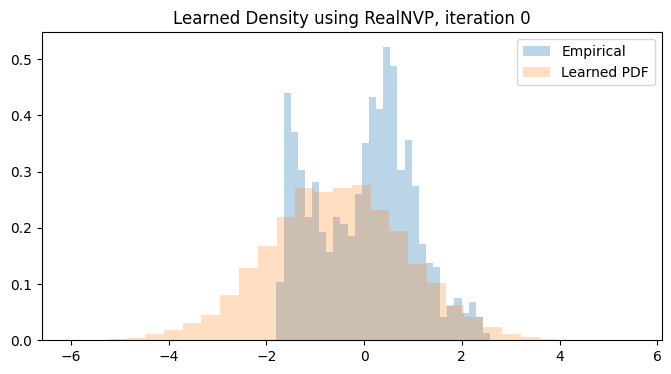

Epoch 500: Avg Loss per epoch = 1.4188,... final loss of training: 1.4188,...Gradient Norm: 0.0028


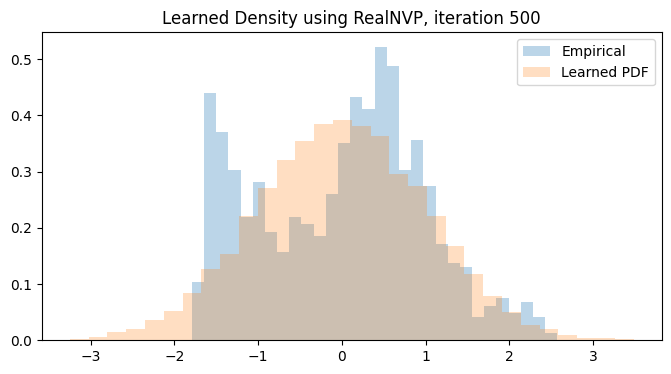

Epoch 1000: Avg Loss per epoch = 1.4188,... final loss of training: 1.4188,...Gradient Norm: 0.0044


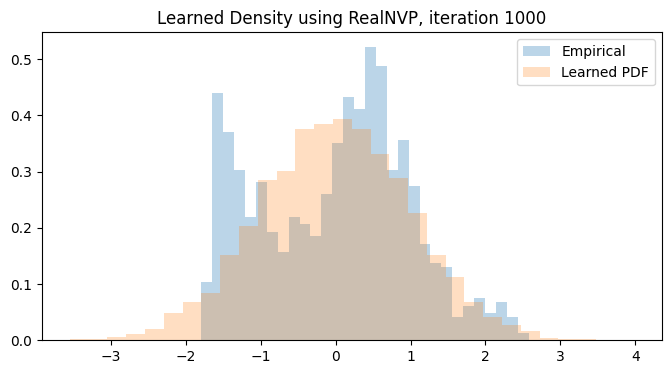

'done'

In [9]:
train_SimpleRealNV(x, multivar_x = False, n_epoch = 1500)

Epoch 0: Avg Loss per epoch = 1.5570,... final loss of training: 1.5570,...Gradient Norm: 0.3154


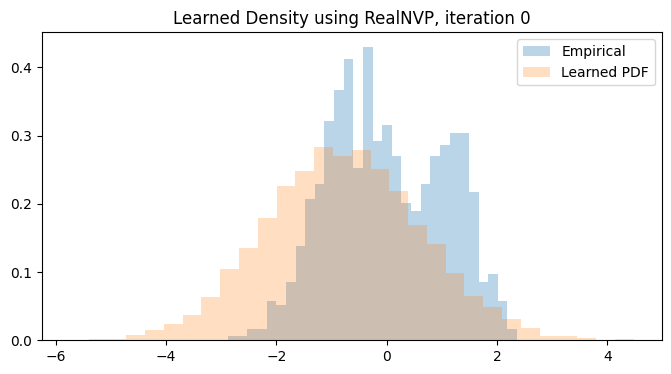

Epoch 500: Avg Loss per epoch = 1.4645,... final loss of training: 1.4645,...Gradient Norm: 0.0000


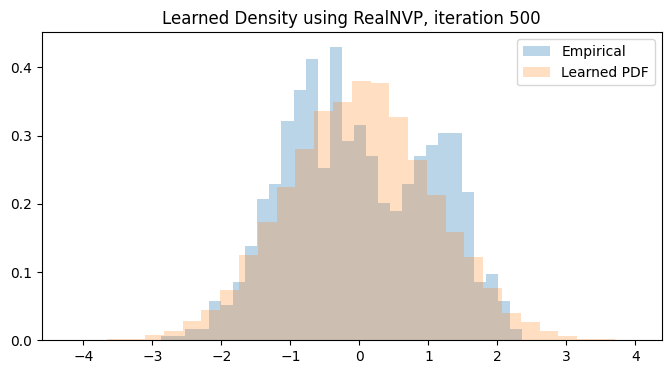

Epoch 1000: Avg Loss per epoch = 1.4645,... final loss of training: 1.4645,...Gradient Norm: 0.0000


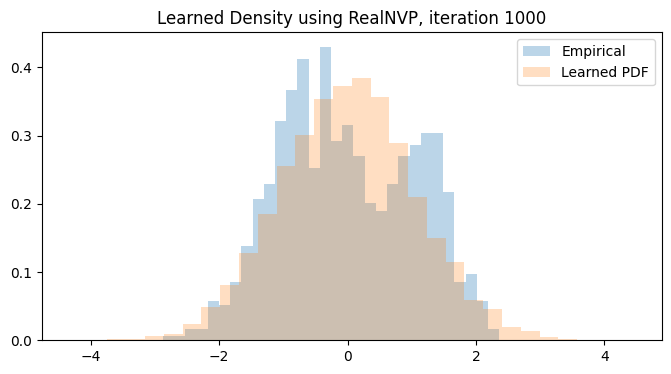

'done'

In [10]:
train_SimpleRealNV(y, multivar_x = False, n_epoch = 1500)

### Train and apply normalizing flow approach via RealNVP using synthetic data + noise {N(0,1)}

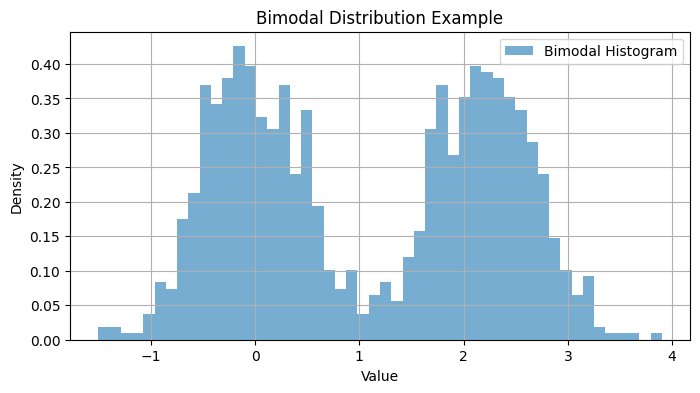

In [11]:
# Generate samples from two Gaussians
# First normal distribution: mean = 0, std = 0.5
normal_1 = np.random.normal(loc=0.0, scale=0.5, size=500)

# Second normal distribution: mean = 1.5, std = 0.5
normal_2 = np.random.normal(loc=2.2, scale=0.5, size=500)

# Combine into a single bimodal vector
bimodal_vector = np.concatenate([normal_1, normal_2])
np.random.shuffle(bimodal_vector)

# Plot it
plt.figure(figsize=(8, 4))
plt.hist(bimodal_vector, bins=50, density=True, alpha=0.6, label="Bimodal Histogram")
plt.title("Bimodal Distribution Example")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# generate random noise
np.random.seed(42)
torch.manual_seed(42)
n = len(bimodal_vector)  # or y.shape[0]
noise = torch.randn(n)  # mean 0, std 1 by default
var = torch.tensor(np.array([bimodal_vector,noise]), dtype=torch.float32 )

Epoch 0: Avg Loss per epoch = 3.4489,... final loss of training: 3.4489,...Gradient Norm: 4.5493


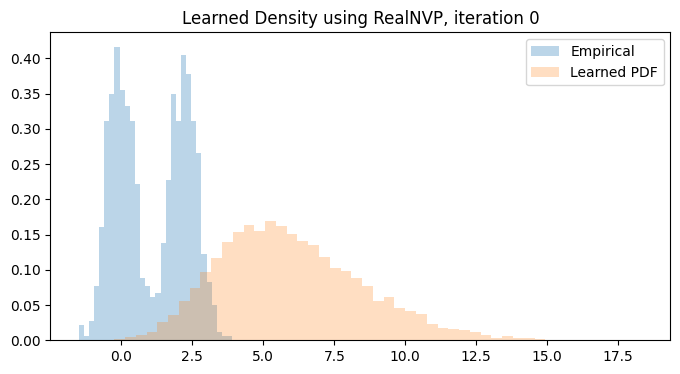

Epoch 500: Avg Loss per epoch = 2.7779,... final loss of training: 2.7779,...Gradient Norm: 6.4324


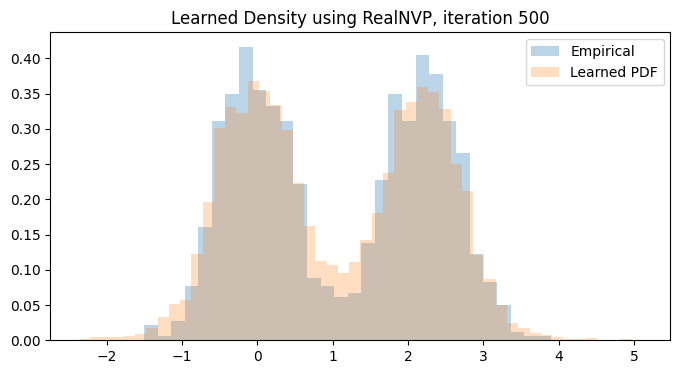

Epoch 1000: Avg Loss per epoch = 2.7500,... final loss of training: 2.7500,...Gradient Norm: 5.8174


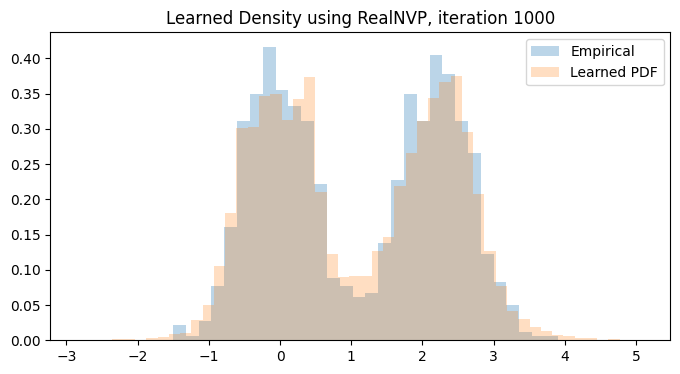

'done'

In [13]:
train_SimpleRealNV(x = var, multivar_x= True, n_epoch= 1500)

### Train and apply normalizing flow approach via RealNVP using real data + noise {N(0,1)}

In [15]:
# generate random noise
np.random.seed(42)
torch.manual_seed(42)
n = len(x)  # or y.shape[0]
noise = torch.randn(n)  # mean 0, std 1 by default
var = torch.tensor(np.array([x,noise]), dtype=torch.float32 )

Epoch 0: Avg Loss per epoch = 3.2902,... final loss of training: 3.2902,...Gradient Norm: 5.3041


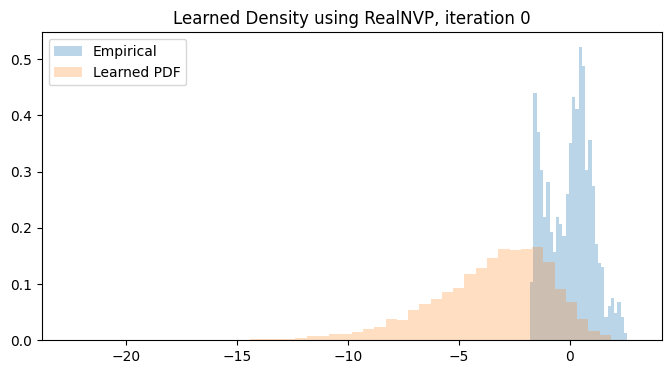

Epoch 500: Avg Loss per epoch = 2.7185,... final loss of training: 2.7185,...Gradient Norm: 3.7987


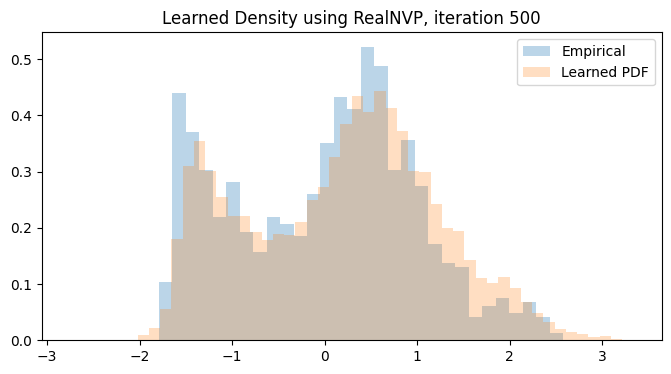

Epoch 1000: Avg Loss per epoch = 2.6920,... final loss of training: 2.6920,...Gradient Norm: 4.3179


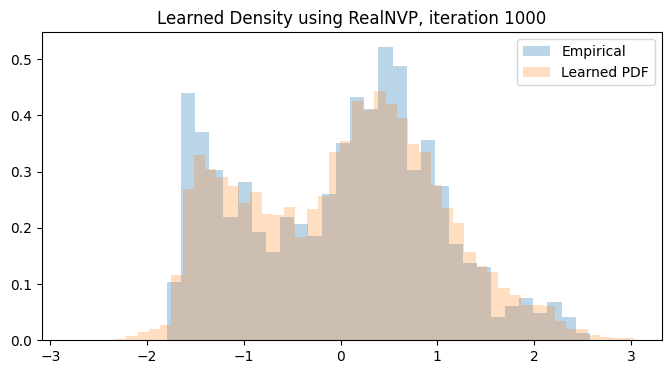

'done'

In [16]:
train_SimpleRealNV(x = var, multivar_x= True, n_epoch= 1500)

In [17]:
n = len(y)  # or y.shape[0]
noise = torch.randn(n)  # mean 0, std 1 by default
var = torch.tensor(np.array([y,noise]), dtype=torch.float32 )

Epoch 0: Avg Loss per epoch = 3.6620,... final loss of training: 3.6620,...Gradient Norm: 11.3762


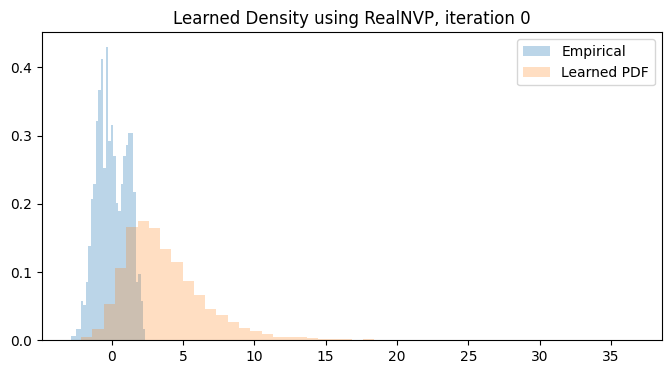

Epoch 500: Avg Loss per epoch = 2.7918,... final loss of training: 2.7918,...Gradient Norm: 1.0370


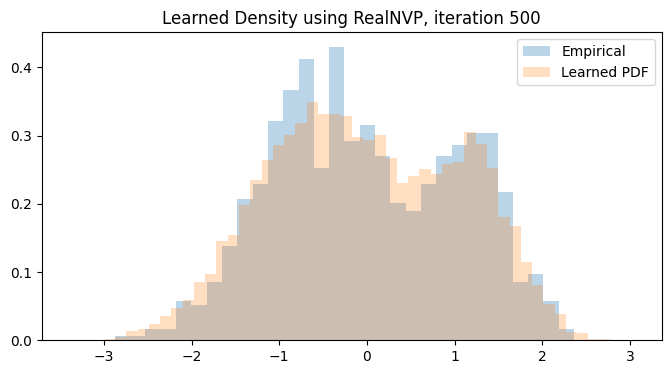

Epoch 1000: Avg Loss per epoch = 2.7837,... final loss of training: 2.7837,...Gradient Norm: 2.2620


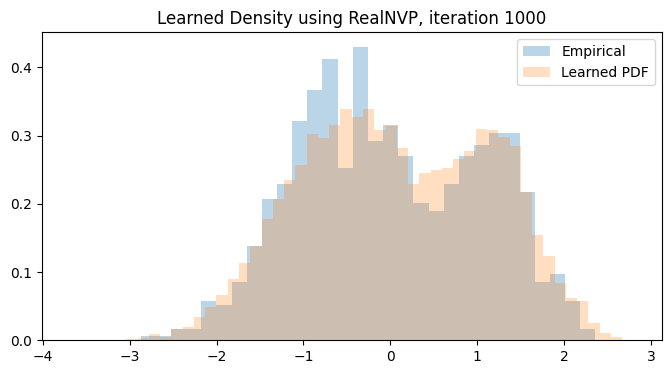

'done'

In [18]:
train_SimpleRealNV(x = var, multivar_x= True, n_epoch= 1500)